**Import Libraries and Define constants**

In [1]:
#### Training based on features of audio
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sknn.mlp import Classifier, Layer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import random
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier





/home/vuthede/.local/lib64/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Load data**

In [2]:

##Loading  data from files
filehandlerInput = open('processed-data/input_VAD.obj', 'rb')
filehandlerOutput = open('processed-data/output_VAD.obj', 'rb')
input = pickle.load(filehandlerInput)
output = pickle.load(filehandlerOutput)
print("Size input, output:", len(input),", ", len(output))

Size input, output: 10018 ,  10018


**Preprocess data**

In [3]:
input_filtered = input[~np.any(np.isnan(input), axis=1)]
output_filtered = output[~np.any(np.isnan(input), axis=1)]
print("Size input, output after remove Nan values ", len(input_filtered), ", ", len(output_filtered))

#Normalize input
input_filtered = (input_filtered - input_filtered.min(axis=0)) / (input_filtered.max(axis=0) - input_filtered.min(axis=0))

#Normalize output
output_filtered = (output_filtered - output_filtered.min(axis=0)) / (output_filtered.max(axis=0) - output_filtered.min(axis=0))
print("Normalize input and output using min-max method")
 


Size input, output after remove Nan values  10009 ,  10009
Normalize input and output using min-max method


**Distribution of lables**

Average labels: 0.3952183723537705
Std labels: 0.1994077352661613


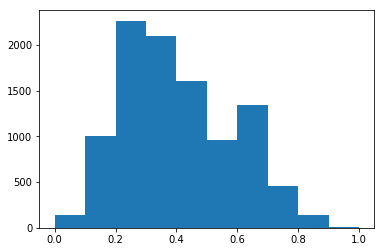

In [4]:
import matplotlib.pyplot as plt
import numpy as np

print("Average labels:", np.average(output_filtered[:,0]))
print("Std labels:", np.std(output_filtered[:,0]))
plt.hist(output_filtered[:,0])
plt.show()



**Shuffer data**

In [5]:
#Shuffer
c = list(zip(input_filtered, output_filtered))
random.shuffle(c)
input_filtered, output_filtered = zip( * c)
input_filtered = np.array(input_filtered)
output_filtered = np.array(output_filtered)


**Split data**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(input_filtered, output_filtered, test_size=0.1, random_state=300)
print("Size training, testing set: ", len(X_train), ", ", len(X_test))



Size training, testing set:  9008 ,  1001


**Training on keras**

In [44]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation



model = Sequential([
    Dense(64, input_shape=(88,), kernel_initializer='normal'),
    Activation('relu'),
    Dense(32, kernel_initializer='normal'),
    Activation('relu'),
    Dense(16,kernel_initializer='normal'),
    Activation('relu'),
    Dense(8, kernel_initializer='normal'),
    Activation('relu'),
    Dense(1),
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train[:,0], validation_data=(X_test, y_test[:,0]), epochs = 10)








Train on 9008 samples, validate on 1001 samples
Epoch 1/10
9008/9008 [==============================] - 1s 108us/step - loss: 0.0547 - val_loss: 0.0425
Epoch 2/10
9008/9008 [==============================] - 1s 76us/step - loss: 0.0382 - val_loss: 0.0402
Epoch 3/10
9008/9008 [==============================] - ETA: 0s - loss: 0.036 - 1s 73us/step - loss: 0.0364 - val_loss: 0.0393
Epoch 4/10
9008/9008 [==============================] - 1s 72us/step - loss: 0.0358 - val_loss: 0.0392
Epoch 5/10
9008/9008 [==============================] - 1s 73us/step - loss: 0.0352 - val_loss: 0.0384
Epoch 6/10
9008/9008 [==============================] - 1s 75us/step - loss: 0.0347 - val_loss: 0.0380
Epoch 7/10
9008/9008 [==============================] - 1s 73us/step - loss: 0.0345 - val_loss: 0.0376
Epoch 8/10
9008/9008 [==============================] - 1s 73us/step - loss: 0.0341 - val_loss: 0.0373
Epoch 9/10
9008/9008 [==============================] - 1s 72us/step - loss: 0.0339 - val_loss: 0.0395


**Playing around with prediction**

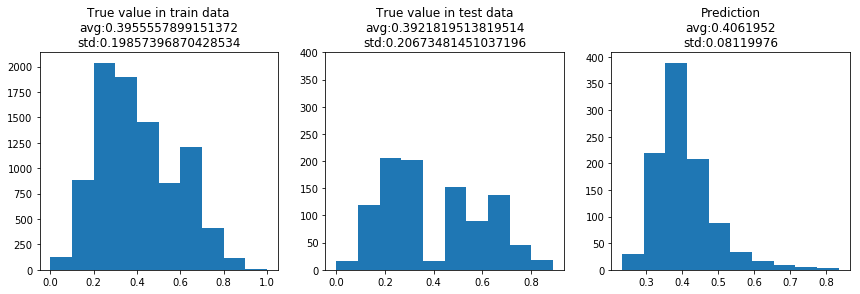

In [45]:
from matplotlib.pyplot import subplots_adjust
predict = model.predict_proba(X_test)
subs = np.abs(predict - y_test[:,0])


fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2)
axs[0].hist(y_train[:,0])
axs[0].set_title("True value in train data\n" + 
                 "avg:" + str(np.average(y_train[:,0])) + 
                 "\nstd:" + str(np.std(y_train[:,0])))
axs[1].hist(y_test[:,0])
axs[1].set_title("True value in test data\n" + 
                 "avg:" + str(np.average(y_test[:,0])) + 
                 "\nstd:" + str(np.std(y_test[:,0])))
axs[1].set_ylim([0,400])
                        
axs[2].hist(predict) 
axs[2].set_title("Prediction\n" +
                "avg:" + str(np.average(predict)) + 
                 "\nstd:" + str(np.std(predict)))
                
# axs[2].hist(subs, bins='auto')
# axs[2].set_title("error on predictions")

plt.show()
plt.close()


**Playing around with predictions**

In [27]:
threshold = 0.1
condition = [sub > threshold for sub in subs[0]]
r = subs[condition]
print(len(r)/ len(subs))

0.5774225774225774


In [10]:
# 4 * 0.16 +1